# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss
import gan.spectral_normalization
from gan.models import Discriminator, Generator


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


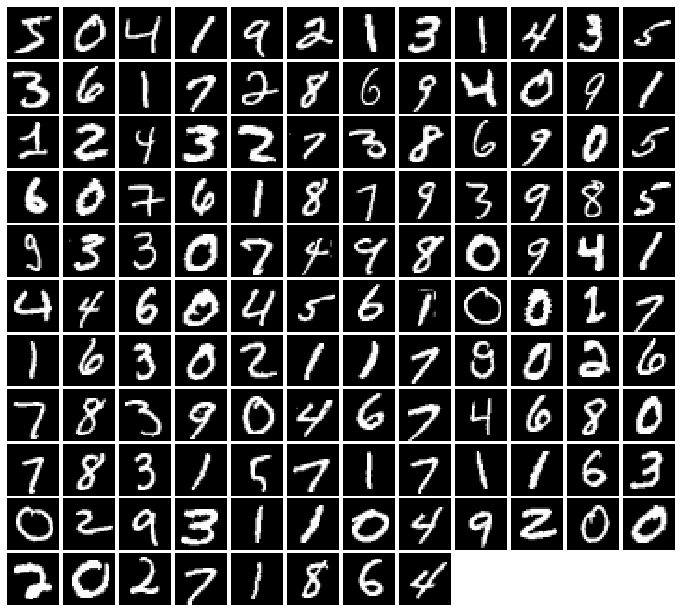

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img

def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    
    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            _, input_channels, img_size, _ = x.shape
            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None

            # Discriminator step
            D_solver.zero_grad()
#             fake_input = sample_noise(batch_size, noise_size).view(batch_size, noise_size, 1, 1).to(device)
            fake_input = sample_noise(batch_size, noise_size).to(device)
            fake_images = G(fake_input).detach()
            fake_images = fake_images.view(batch_size, input_channels, img_size, img_size)
            logits_fake = D(fake_images)
            logits_real = D(real_images)
            d_error = discriminator_loss(logits_real, logits_fake)
            d_error.backward()
            D_solver.step()

            # Generator Step
            G_solver.zero_grad()
#             fake_input = sample_noise(batch_size, noise_size).view(batch_size, noise_size, 1, 1).to(device)
            fake_input = sample_noise(batch_size, noise_size).to(device)
            fake_images = G(fake_input)
            fake_images = fake_images.view(batch_size, input_channels, img_size, img_size)
            logits_fake = D(fake_images)
            g_error = generator_loss(logits_fake)
            g_error.backward()
            G_solver.step()


            # Logging and output visualization
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1


EPOCH:  1
Iter: 0, D: 1.424, G:0.6787


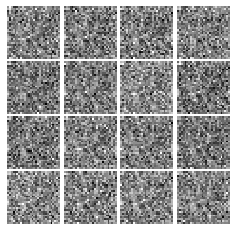


Iter: 250, D: 1.438, G:0.8682


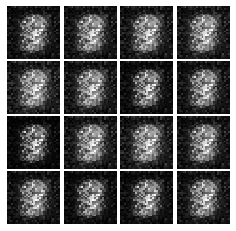


EPOCH:  2
Iter: 500, D: 0.836, G:1.578


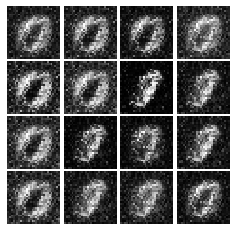


Iter: 750, D: 1.079, G:1.471


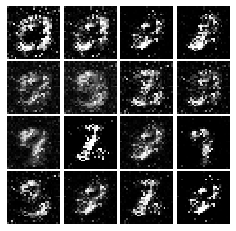


EPOCH:  3
Iter: 1000, D: 1.344, G:1.178


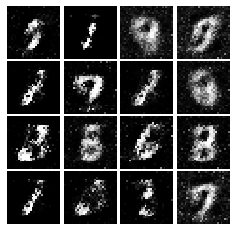


Iter: 1250, D: 1.104, G:1.285


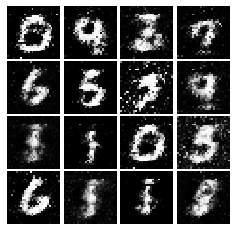


EPOCH:  4
Iter: 1500, D: 1.126, G:1.029


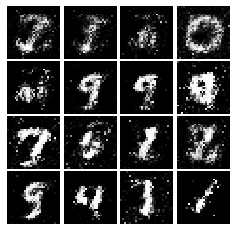


Iter: 1750, D: 1.029, G:1.192


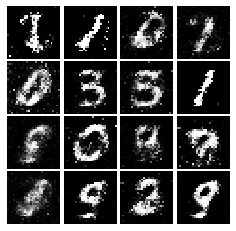


EPOCH:  5
Iter: 2000, D: 1.278, G:0.8848


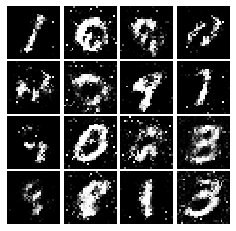


Iter: 2250, D: 1.236, G:1.044


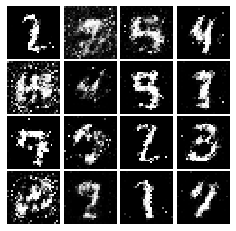


EPOCH:  6
Iter: 2500, D: 1.306, G:0.9178


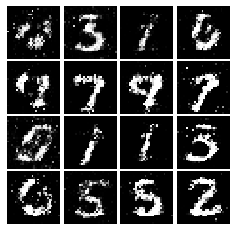


Iter: 2750, D: 1.488, G:0.8634


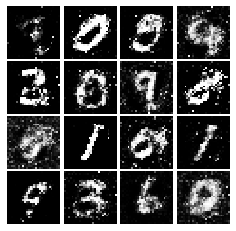


EPOCH:  7
Iter: 3000, D: 1.293, G:0.857


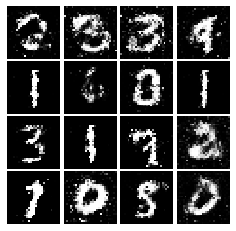


Iter: 3250, D: 1.291, G:0.834


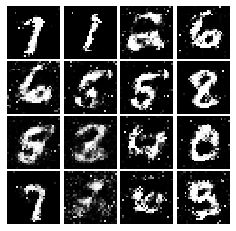


EPOCH:  8
Iter: 3500, D: 1.355, G:0.9911


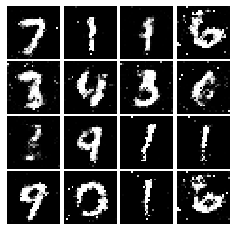


EPOCH:  9
Iter: 3750, D: 1.228, G:0.8615


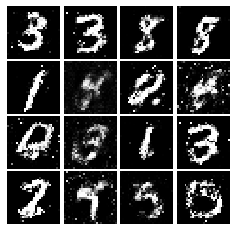


Iter: 4000, D: 1.297, G:0.7712


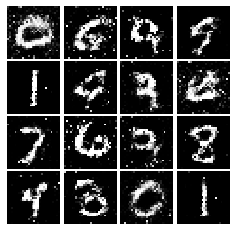


EPOCH:  10
Iter: 4250, D: 1.282, G:0.8818


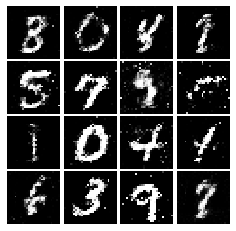


Iter: 4500, D: 1.29, G:0.84


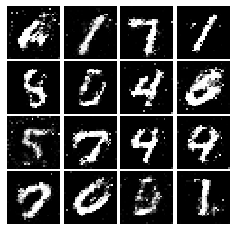

In [9]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

NOISE_DIM = 100 

# D = Discriminator().to(device)
# G = Generator(noise_dim=NOISE_DIM).to(device)


D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5675, G:0.525


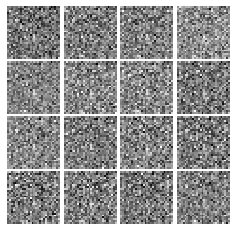


Iter: 250, D: 0.1141, G:0.321


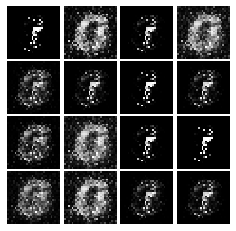


EPOCH:  2
Iter: 500, D: 0.1062, G:0.3517


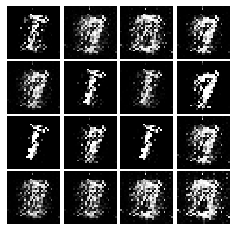


Iter: 750, D: 0.1051, G:0.3551


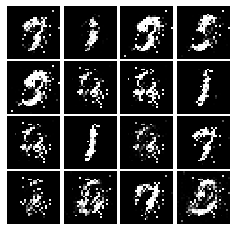


EPOCH:  3
Iter: 1000, D: 0.07739, G:0.3727


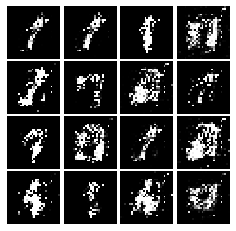


Iter: 1250, D: 0.1378, G:0.3139


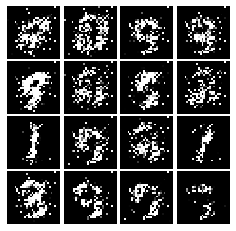


EPOCH:  4
Iter: 1500, D: 0.1361, G:0.2116


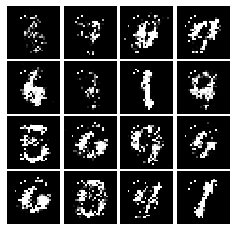


Iter: 1750, D: 0.1818, G:0.2461


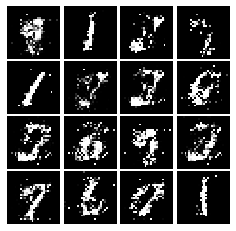


EPOCH:  5
Iter: 2000, D: 0.1885, G:0.2319


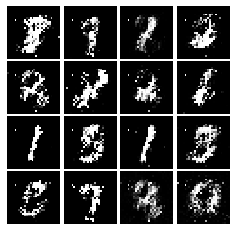


Iter: 2250, D: 0.2177, G:0.2085


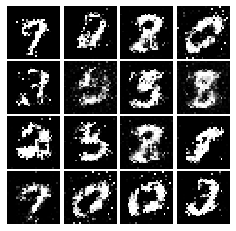


EPOCH:  6
Iter: 2500, D: 0.228, G:0.1802


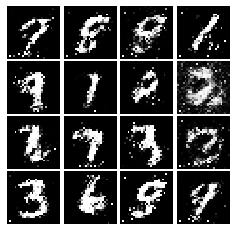


Iter: 2750, D: 0.228, G:0.1914


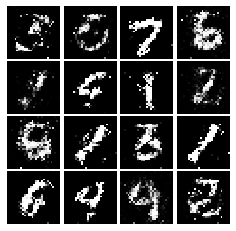


EPOCH:  7
Iter: 3000, D: 0.2192, G:0.1903


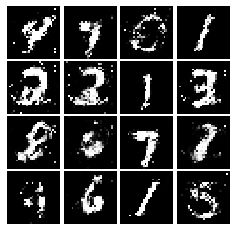


Iter: 3250, D: 0.1957, G:0.1848


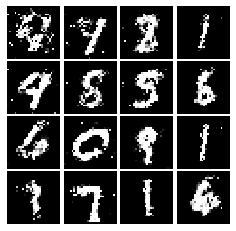


EPOCH:  8
Iter: 3500, D: 0.2605, G:0.1705


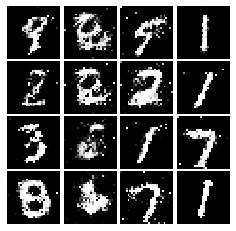


EPOCH:  9
Iter: 3750, D: 0.2059, G:0.1845


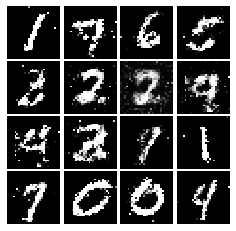


Iter: 4000, D: 0.2335, G:0.1419


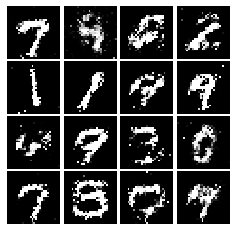


EPOCH:  10
Iter: 4250, D: 0.2312, G:0.184


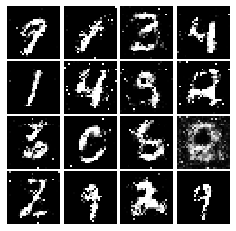


Iter: 4500, D: 0.1996, G:0.1762


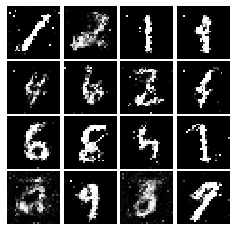

In [10]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)